In [1]:
import numpy as np
import warnings
import networkx as nx
import scipy.io
import matplotlib.pyplot as plt
from src import Classifier
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

In [2]:
def parse_mat_file(path):
    
    edges = []
    g = nx.Graph()
    mat = scipy.io.loadmat(path)
    nodes = mat['network'].tolil()
    subs_coo = mat['group'].tocoo()
    
    for start_node,end_nodes in enumerate(nodes.rows, start=0):
        for end_node in end_nodes:
            edges.append((start_node,end_node))
    
    g.add_edges_from(edges)
    g.name = path
    print(nx.info(g) + "\n---------------------------------------\n")
        
    return g, subs_coo


In [3]:
def load_embeddings(fname):
    try:
        word_vec = KeyedVectors.load_word2vec_format(fname, binary=False)
        print("Embeddings successfully loaded from "+fname)
        return word_vec, True
    except IOError:
        print("Embedding file not found. Proceeding to generate new embeddings")
        # Y/N here
        return _, False

In [4]:
def eval_classifier(G, subs_coo, word_vec):
    #Sometimes the model doesn't predict anything at all for some inputs. Its either the model's fault or that user has no subscriptions at
    #all, in that case the model is predicting properly but of course a zero output would raise exceptions during sklearn's
    #F1 score function.
    #Currently evaluating performance with OVR Logistic Regression.
    print("\t**Evaluating classifier performance with the embeddings**")

    results = Classifier.evaluate(G, subs_coo, word_vec)
    
    print("\n Evaluation completed using the following:")
    for i in results.keys():
        print("--> ",i)
    
    print("\nPrinting evaluation results : ")
    trainsize = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    for (name,res) in results.items():
        print("\n\nClassifier : ",name)
        for (tr_size,res_) in zip(trainsize,res):
            print("\tTraining size : ",tr_size)
            print("\t\tMicro F1: ",res_[0])
            print("\t\tMacro F1: ",res_[1])
        
        avg = np.average(res,axis=0)
        print("\t---------------------------------------")
        print("\t Average Micro F1 : ",avg[0])
        print("\t Average Macro F1 : ",avg[1])
        Classifier.plot_graph(trainsize, res)


Name: graph/blogcatalog.mat
Type: Graph
Number of nodes: 10312
Number of edges: 333983
Average degree:  64.7756
---------------------------------------

Embeddings successfully loaded from embeddings/blogcatalog_embeddings_dim-128_p-0.25_q-0.25.txt
	**Evaluating classifier performance with the embeddings**

 Evaluation completed using the following:
-->  Logistic_Regression

Printing evaluation results : 


Classifier :  Logistic_Regression
	Training size :  0.1
		Micro F1:  0.34414041542116963
		Macro F1:  0.20663374057704248
	Training size :  0.2
		Micro F1:  0.3672887506480041
		Macro F1:  0.23200387853794346
	Training size :  0.3
		Micro F1:  0.3898456057007126
		Macro F1:  0.2582933405279603
	Training size :  0.4
		Micro F1:  0.39072771306654364
		Macro F1:  0.26335774887371927
	Training size :  0.5
		Micro F1:  0.3962577962577963
		Macro F1:  0.26816355803585873
	Training size :  0.6
		Micro F1:  0.4051664355062413
		Macro F1:  0.2866259781575974
	Training size :  0.7
		Micro F1:

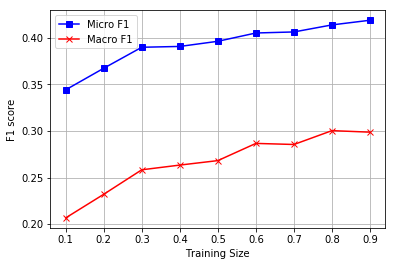

In [5]:
warnings.filterwarnings("ignore")
G, subs_coo = parse_mat_file('graph/blogcatalog.mat')
embeddings, _ = load_embeddings('embeddings/blogcatalog_embeddings_dim-128_p-0.25_q-0.25.txt')
eval_classifier(G, subs_coo, embeddings)